<a href="https://colab.research.google.com/github/avishek-astra/Deep_Learning_Experiments/blob/main/FFN_shiftedMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import dataset

In [7]:
# import dataset (comes with colab!)
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

In [8]:
# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)


(20000,)
(20000, 784)


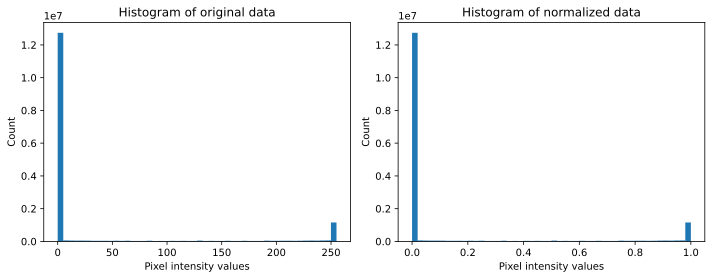

In [9]:
#normalize the data to a range of [0 1]
dataNorm=data/np.max(data)
fig,ax=plt.subplots(1,2,figsize=(10,4))
ax[0].hist(data.flatten(),50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[1].hist(dataNorm.flatten(),50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
plt.tight_layout()
plt.show()

Create train/TEST GROUPS USING DataLoader

In [10]:
# Step 1: convert to tensor
dataT   = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

Shift the test images by a few pixels


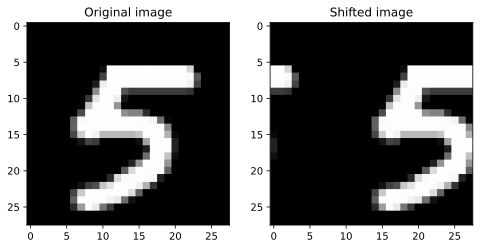

In [11]:
#grab one image data
tmp=test_loader.dataset.tensors[0][0,:]
tmp=tmp.reshape(28,28)
#shif the image(pytorch call it 'rolling')
tmpS=torch.roll(tmp,8,dims=1)
#now show the daga
fig,ax=plt.subplots(1,2,figsize=(8,4))
ax[0].imshow(tmp,cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(tmpS,cmap='gray')
ax[1].set_title('Shifted image')
plt.show()

Repeat for all images in the test set

In [13]:
for i in range(test_loader.dataset.tensors[0].shape[0]):
  #get the image
  img=test_loader.dataset.tensors[0][i,:]
  #reshape and roll by max 10 pixels
  randroll=np.random.randint(-10,11)
  img=torch.roll(img.reshape(28,28),randroll,dims=1)
  #save the image
  test_loader.dataset.tensors[0][i,:]=img.reshape(-1)


In [ ]:
#check all variables in workspace
%whos

Create the DL model

In [14]:
def createTheMNISTNet():
  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()
      ###input layer
      self.input = nn.Linear(784,64)
      ###hidden layer
      self.fc1 = nn.Linear(64,32)
      self.fc2 = nn.Linear(32,32)
      ###output layer
      self.output = nn.Linear(32,10)
    #forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)
      # NEW HERE: log-softmax the output, because I'm using NLLLoss instead of CrossEntropyLoss
  #create the model instance
  net = mnistNet()
  #loss function
  lossfun = nn.CrossEntropyLoss()
  #optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)
  return net,lossfun, optimizer

Create a function that trains the model

In [15]:
# a function that trains the model
def function2trainTheModel():
  #number of epocs
  numepochs=50
  #create a new model
  net,lossfun,optimizer=createTheMNISTNet()
  #initialize losses
  losses=torch.zeros(numepochs)
  trainAcc=[]
  testAcc=[]
  #loop over epochs
  for epochi in range(numepochs):
    #loop over training data batches
    batchAcc=[]
    batchLoss=[]
    for X,y in train_loader:
      #forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net

Run the model and show the results

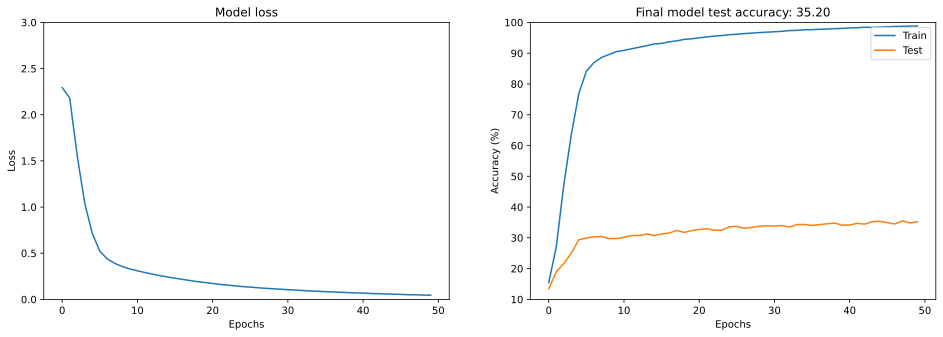

In [16]:
trainAcc, testAcc,losses, net=function2trainTheModel()
fig,ax=plt.subplots(1,2,figsize=(16,5))
ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')
ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}')
ax[1].legend()
plt.show()

Inspect the results in more detail